<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Import Required libraries</b></font>
</p>



In [ ]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import random
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b> load Dataset</b></font>
</p>

Selected classes: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24']
Train images shape: (105, 224, 224, 3)
Train labels shape: (105,)


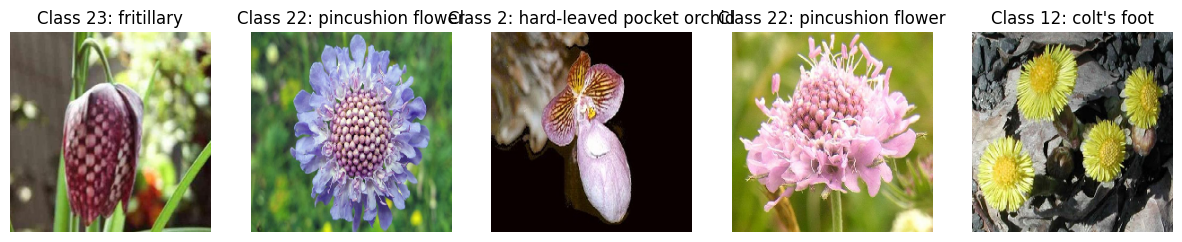

In [ ]:
# Dataset directory path
data_dir = "/kaggle/input/oxford-102-flower-dataset/102 flower/flowers"

# Load JSON file containing class names
class_to_name_path = "/kaggle/input/oxford-102-flower-dataset/102 flower/cat_to_name.json"
with open(class_to_name_path, 'r') as f:
    class_names_dict = json.load(f)

train_dir = os.path.join(data_dir, "test")


all_classes = sorted(os.listdir(train_dir))

# Select the first 20 classes
selected_classes = all_classes[:20]
print("Selected classes:", selected_classes)

# Load images and labels for the selected classes
train_images = []
train_labels = []

for folder in selected_classes:
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            train_images.append(img_array)
            train_labels.append(int(folder))


train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Print the shapes of the arrays
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)


train_class_names = [class_names_dict[str(label)] for label in train_labels]

# Randomly select 5 images from different classes
random_indices = random.sample(range(len(train_images)), 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, idx in enumerate(random_indices):
    axes[i].imshow(train_images[idx])
    axes[i].set_title(f"Class {train_labels[idx]}: {train_class_names[idx]}")
    axes[i].axis('off')
plt.show()


<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Selected Support Set and Query Set and Siamese Train Set</b></font>
</p>

In [ ]:
def create_support_query_siamese_train_sets(train_images, train_labels, class_names_dict, selected_classes=[100, 13, 2], n_shots=3):
    support_images = []
    support_labels = []
    query_images = []
    query_labels = []

    used_indices = set()

    print("Selected classes for Support Set and Query Set:", selected_classes)

    query_distribution = [2, 1, 1]

    for idx, class_id in enumerate(selected_classes):
        class_indices = np.where(train_labels == class_id)[0]
        class_images = train_images[class_indices]

        # Select support set
        support_set_indices = random.sample(list(class_indices), n_shots)
        support_images.extend(train_images[support_set_indices])
        support_labels.extend([class_id] * n_shots)
        used_indices.update(support_set_indices)

        # Select query set
        query_set_indices = [i for i in class_indices if i not in support_set_indices]
        n_query = query_distribution[idx]
        selected_query_indices = random.sample(query_set_indices, n_query)

        query_images.extend(train_images[selected_query_indices])
        query_labels.extend([class_id] * n_query)
        used_indices.update(selected_query_indices)

        print(f"\nClass {class_id} ({class_names_dict[str(class_id)]}):")
        print(f"Indices of images selected for Support Set: {support_set_indices}")
        print(f"Indices of images selected for Query Set: {selected_query_indices}")

    # Select remaining images for Siamese training (all unused images)
    siamese_train_indices = [i for i in range(len(train_labels)) if i not in used_indices]
    siamese_train_images = train_images[siamese_train_indices]
    siamese_train_labels = train_labels[siamese_train_indices]

    return (np.array(support_images), np.array(support_labels),
            np.array(query_images), np.array(query_labels),
            np.array(siamese_train_images), np.array(siamese_train_labels))


support_images, support_labels, query_images, query_labels, siamese_train_images, siamese_train_labels = create_support_query_siamese_train_sets(train_images, train_labels, class_names_dict)

print("*************************")

print("Support Set images shape:", support_images.shape)
print("Support Set labels shape:", support_labels.shape)

print("*************************")

print("Query Set images shape:", query_images.shape)
print("Query Set labels shape:", query_labels.shape)

print("*************************")

print("Siamese Train images shape:", siamese_train_images.shape)
print("Siamese Train labels shape:", siamese_train_labels.shape)


Selected classes for Support Set and Query Set: [100, 13, 2]

Class 100 (blanket flower):
Indices of images selected for Support Set: [10, 9, 8]
Indices of images selected for Query Set: [14, 13]

Class 13 (king protea):
Indices of images selected for Support Set: [46, 47, 49]
Indices of images selected for Query Set: [45]

Class 2 (hard-leaved pocket orchid):
Indices of images selected for Support Set: [85, 83, 82]
Indices of images selected for Query Set: [84]
*************************
Support Set images shape: (9, 224, 224, 3)
Support Set labels shape: (9,)
*************************
Query Set images shape: (4, 224, 224, 3)
Query Set labels shape: (4,)
*************************
Siamese Train images shape: (92, 224, 224, 3)
Siamese Train labels shape: (92,)


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Show Support and Query Sets</b></font>
</p>

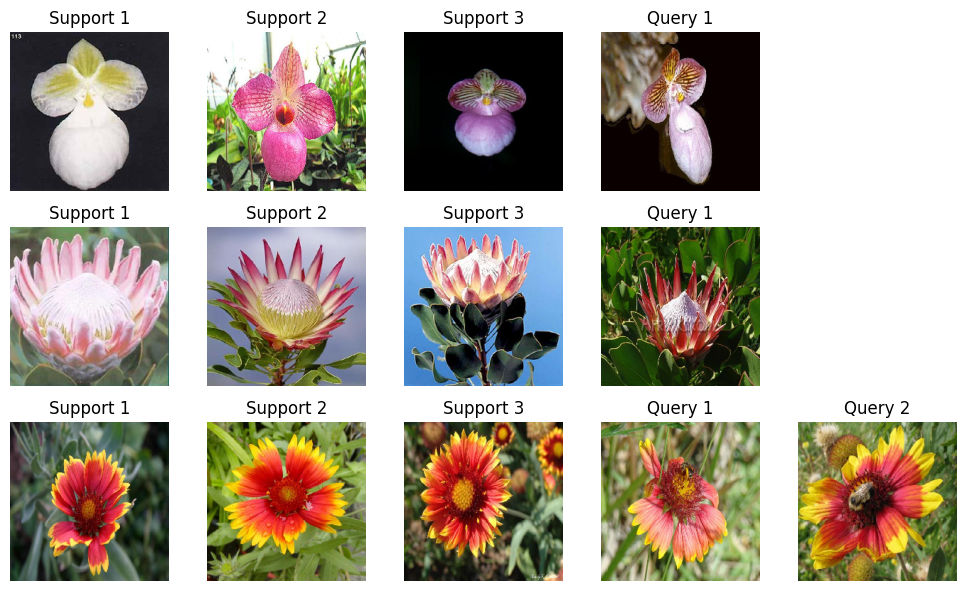

In [ ]:
def visualize_support_query_sets(support_images, support_labels, query_images, query_labels, class_names_dict):
    unique_classes = np.unique(support_labels)

    num_classes = len(unique_classes)
    num_cols = 3 + 2

    fig, axes = plt.subplots(num_classes, num_cols, figsize=(num_cols * 2, num_classes * 2))

    if num_classes == 1:
        axes = [axes]

    for row_idx, class_id in enumerate(unique_classes):
        # Get support images for the class
        support_idxs = np.where(support_labels == class_id)[0]
        support_imgs = support_images[support_idxs]

        # Get query images for the class
        query_idxs = np.where(query_labels == class_id)[0]
        query_imgs = query_images[query_idxs]

        # Normalize images if needed (Check pixel range)
        def preprocess_image(image):
            """ Convert images to uint8 format if necessary. """
            if image.max() <= 1:
                image = (image * 255).astype(np.uint8)
            return image

        # Display support images
        for i in range(3):
            img = preprocess_image(support_imgs[i])
            axes[row_idx, i].imshow(img)
            axes[row_idx, i].set_title(f"Support {i+1}")
            axes[row_idx, i].axis("off")

        # Display query images
        for j in range(len(query_imgs)):
            img = preprocess_image(query_imgs[j])
            axes[row_idx, j + 3].imshow(img)
            axes[row_idx, j + 3].set_title(f"Query {j+1}")
            axes[row_idx, j + 3].axis("off")

        # Hide any remaining empty subplots
        for k in range(len(query_imgs) + 3, num_cols):
            axes[row_idx, k].axis("off")

    plt.tight_layout()
    plt.show()


visualize_support_query_sets(support_images, support_labels, query_images, query_labels, class_names_dict)


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Create Pair of Three for Triplet Network Train</b></font>
</p>

In [ ]:
def create_triplet_pairs_from_siamese_train(siamese_train_images, siamese_train_labels):
    anchor_images = []
    positive_images = []
    negative_images = []

    # Generate triplet pairs
    for i in range(len(siamese_train_images)):
        anchor_img = siamese_train_images[i]
        anchor_label = siamese_train_labels[i]

        positive_idx = np.random.choice(np.where(siamese_train_labels == anchor_label)[0])
        positive_img = siamese_train_images[positive_idx]

        negative_label = np.random.choice([label for label in np.unique(siamese_train_labels) if label != anchor_label])
        negative_idx = np.random.choice(np.where(siamese_train_labels == negative_label)[0])
        negative_img = siamese_train_images[negative_idx]

        anchor_images.append(anchor_img)
        positive_images.append(positive_img)
        negative_images.append(negative_img)

    # Convert lists to numpy arrays
    anchor_images = np.array(anchor_images)
    positive_images = np.array(positive_images)
    negative_images = np.array(negative_images)

    # Print statistics
    print(f"Total triplets: {len(anchor_images)}")
    print(f"Anchor images shape: {anchor_images.shape}")
    print(f"Positive images shape: {positive_images.shape}")
    print(f"Negative images shape: {negative_images.shape}")

    return anchor_images, positive_images, negative_images


# Example usage
anchor_images, positive_images, negative_images = create_triplet_pairs_from_siamese_train(siamese_train_images, siamese_train_labels)


Total triplets: 92
Anchor images shape: (92, 224, 224, 3)
Positive images shape: (92, 224, 224, 3)
Negative images shape: (92, 224, 224, 3)


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Build the Feature Extractor Model</b></font>
</p>

In [ ]:

def build_feature_extractor():
    # Load the ResNet50 model without the top layer (classification layer)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False


    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)

    # Create the model with the input being from ResNet50 and output from the dense layer
    feature_extractor = models.Model(inputs=base_model.input, outputs=x)
    print("Feature extractor model has been successfully built.")

    return feature_extractor


model = build_feature_extractor()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Feature extractor model has been successfully built.


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Building a Triple Network Model with Triplet Loss Function</b></font>
</p>

In [ ]:
def triple_loss(y_true, y_pred, margin=0.1):
    positive_distance = y_pred[:, 0]
    negative_distance = y_pred[:, 1]
    loss = tf.maximum(positive_distance - negative_distance + margin, 0)
    return tf.reduce_mean(loss)

# Euclidean distance function
def triplet_distance(vectors):
    tensor_1, tensor_2 = vectors
    distance = tf.sqrt(tf.reduce_sum(tf.square(tensor_1 - tensor_2), axis=-1, keepdims=True) + 1e-7)
    distance = tf.clip_by_value(distance, 1e-7, 1e7)
    return distance


# Mean Squared Error (MSE) metric
def mse_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Build the Siamese model with Triple Loss
def build_siamese_model_with_triple_loss():
    feature_extractor = build_feature_extractor()

    input_a = layers.Input(shape=(224, 224, 3))
    input_b = layers.Input(shape=(224, 224, 3))
    input_c = layers.Input(shape=(224, 224, 3))

    feat_a = feature_extractor(input_a)
    feat_b = feature_extractor(input_b)
    feat_c = feature_extractor(input_c)

    # Calculate the positive and negative distances using triplet_distance
    positive_distance = layers.Lambda(triplet_distance, output_shape=(1,))([feat_a, feat_b])
    negative_distance = layers.Lambda(triplet_distance, output_shape=(1,))([feat_a, feat_c])

    distances = layers.Concatenate(axis=-1)([positive_distance, negative_distance])

    # Create the Siamese model
    siamese_network = models.Model(inputs=[input_a, input_b, input_c], outputs=distances)

    # Compile the model with Adam optimizer and triple loss
    siamese_network.compile(optimizer=Adam(learning_rate=0.0001), loss=triple_loss, metrics=[mse_metric])

    return siamese_network

# Build and compile the Siamese model with Triple Loss
siamese_model = build_siamese_model_with_triple_loss()

# Display the model summary
siamese_model.summary()


Feature extractor model has been successfully built.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 128)            │     24,145,152 │ input_layer_2[0][0],   │
│                           │                        │                │ input_layer_3[0][0],   │
│                           │                        │                │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ functional_1[0][0],    │
│                           │                        │                │ functional_1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1)              │              0 │ functional_1[0][0],    │
│                           │                        │                │ functional_1[2][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2)              │              0 │ lambda[0][0],          │
│                           │                        │                │ lambda_1[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,145,152 (92.11 MB)

 Trainable params: 557,440 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Fit Model</b></font>
</p>

In [ ]:
# Split the triplets into training and validation sets
train_anchor, validation_anchor, train_positive, validation_positive, train_negative, validation_negative = train_test_split(
    anchor_images, positive_images, negative_images, test_size=0.2, random_state=42
)


dummy_train_labels = np.zeros((train_anchor.shape[0], 1))
dummy_validation_labels = np.zeros((validation_anchor.shape[0], 1))


siamese_model.fit(
    [train_anchor, train_positive, train_negative],
    dummy_train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(
        [validation_anchor, validation_positive, validation_negative],
        dummy_validation_labels
    )
)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 0.2666 - mse_metric: 20.2320 - val_loss: 0.1356 - val_mse_metric: 0.2200
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.2452 - mse_metric: 19.9383 - val_loss: 0.1348 - val_mse_metric: 0.2193
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.2460 - mse_metric: 19.9270 - val_loss: 0.1351 - val_mse_metric: 0.2167
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.4338 - mse_metric: 19.9075 - val_loss: 0.1359 - val_mse_metric: 0.2164
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.3332 - mse_metric: 18.7605 - val_loss: 0.1366 - val_mse_metric: 0.2166
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.2137 - mse_metric: 18.9215 - val_loss: 0.1371 - val_mse_metric: 0.2181
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.2572 - mse_metric: 18.4924 - val_loss: 0.1372 - val_mse_metric: 0.2165
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.2919 - mse_metric: 18.910

<p style="text-align:center;">
    <font face="Georgia" size=6 color="red"><b>Few Shot Learning</b></font>
</p>

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Create Pair of Three from Support Set</b></font>
</p>

In [ ]:
def create_triplets_from_support_pairs(support_images, support_labels):
    anchor_images = []
    positive_images = []
    negative_images = []


    for i in range(len(support_images)):
        anchor_img = support_images[i]
        anchor_label = support_labels[i]


        positive_indices = np.where(support_labels == anchor_label)[0]
        positive_indices = positive_indices[positive_indices != i]
        positive_idx = np.random.choice(positive_indices)
        positive_img = support_images[positive_idx]


        negative_label = np.random.choice([label for label in np.unique(support_labels) if label != anchor_label])
        negative_indices = np.where(support_labels == negative_label)[0]
        negative_idx = np.random.choice(negative_indices)
        negative_img = support_images[negative_idx]

        anchor_images.append(anchor_img)
        positive_images.append(positive_img)
        negative_images.append(negative_img)

    return np.array(anchor_images), np.array(positive_images), np.array(negative_images)

anchor_images, positive_images, negative_images = create_triplets_from_support_pairs(support_images, support_labels)

print(f"Anchor images shape: {anchor_images.shape}")
print(f"Positive images shape: {positive_images.shape}")
print(f"Negative images shape: {negative_images.shape}")


Anchor images shape: (9, 224, 224, 3)
Positive images shape: (9, 224, 224, 3)
Negative images shape: (9, 224, 224, 3)


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Train the Triple model on Support pairs</b></font>
</p>

In [ ]:
dummy_labels = np.zeros((anchor_images.shape[0], 2))

siamese_model.fit(
    [anchor_images, positive_images, negative_images],
    dummy_labels,
    epochs=30,
    batch_size=32
)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 0.3281 - mse_metric: 10.9737
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2265 - mse_metric: 10.7400
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2832 - mse_metric: 11.2122
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1876 - mse_metric: 10.5325
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2356 - mse_metric: 12.0444
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2555 - mse_metric: 11.2869
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2799 - mse_metric: 10.2229
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1032 - mse_metric: 11.4900
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1832 - mse_metric: 10.2950
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1864 - mse_metric: 10.9666
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1705 - mse_metric: 10.1680
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Evaluation</b></font>
</p>

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Query Set Prediction </b></font>
</p>

In [ ]:
def predict_query_class_triplet(model, support_images, support_labels, query_images, query_labels):
    predictions = []

    for i, query_img in enumerate(query_images):
        min_distance = float("inf")
        best_class = None

        for j, support_img in enumerate(support_images):

            distance = model.predict([
                np.expand_dims(query_img, axis=0),
                np.expand_dims(support_img, axis=0)
            ])[0][0]


            if distance < min_distance:
                min_distance = distance
                best_class = support_labels[j]


        predictions.append(best_class)

    return predictions


In [ ]:
predicted_classes = predict_query_class_triplet(
    siamese_model, support_images, support_labels, query_images, query_labels
)


correct_count = 0
total_queries = len(query_images)

print("\nQuery Predictions:\n")
for i, (pred, true_class) in enumerate(zip(predicted_classes, query_labels)):
    is_correct = "Correct" if pred == true_class else "Wrong"
    if pred == true_class:
        correct_count += 1
    print(f"Query {i+1}: True Class = {true_class}, Predicted Class = {pred} --> {is_correct}")

accuracy = (correct_count / total_queries) * 100
print(f"\n Classification Accuracy: {accuracy:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

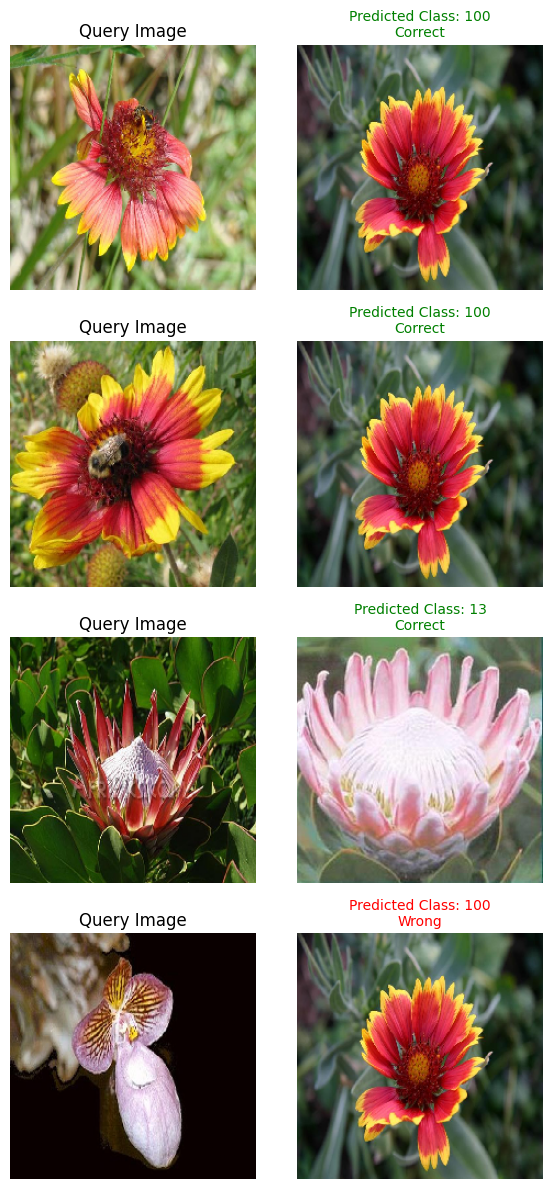

In [ ]:
def display_query_predictions_with_support(query_images, query_labels, predicted_classes, support_images, support_labels):

    num_samples = len(query_images)
    fig, axes = plt.subplots(num_samples, 2, figsize=(6, num_samples * 3))

    for i in range(num_samples):

        axes[i, 0].imshow(query_images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Query Image")

        true_class = query_labels[i]
        predicted_class = predicted_classes[i]


        closest_support_idx = np.where(support_labels == predicted_class)[0][0]
        closest_support_img = support_images[closest_support_idx]


        axes[i, 1].imshow(closest_support_img)
        axes[i, 1].axis('off')


        if true_class == predicted_class:
            title_color = "green"
            result_text = "Correct"
        else:
            title_color = "red"
            result_text = "Wrong"

        axes[i, 1].set_title(f"Predicted Class: {predicted_class}\n{result_text}",
                             color=title_color, fontsize=10)

    plt.tight_layout()
    plt.show()


display_query_predictions_with_support(query_images, query_labels, predicted_classes, support_images, support_labels)


In [ ]:
# Sahar Abdi